## Лабораторная работа №6. Сегментация изображений в Python
### Патракова Е.С.,  РИМ-181226

In [1]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imsave,imshow,imread
import skimage.segmentation as seg
import skimage.filters as filters
from skimage.morphology import watershed
import skimage.draw as draw
import skimage.color as color
from skimage.filters import sobel
from skimage.feature import canny
from scipy import ndimage as ndi
import cv2

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Сегментация изображения

In [2]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x230688050b8>)

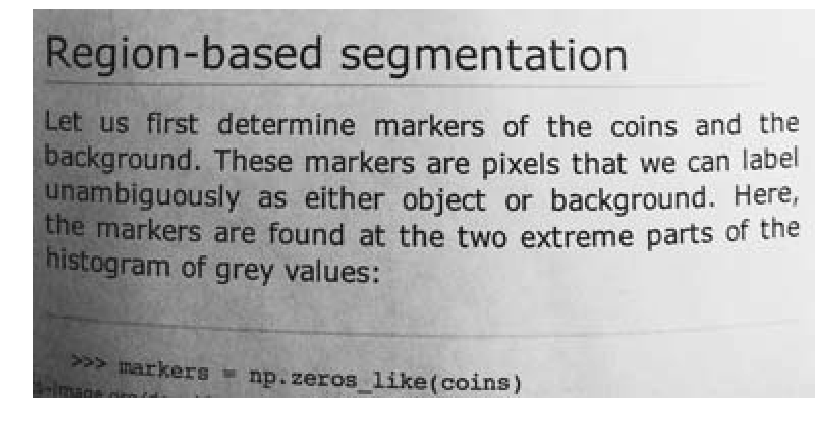

In [3]:
text = data.page()
image_show(text)

#### Построение гистограммы, показывающей количество пикселей в изображении с различными значениями интенсивности

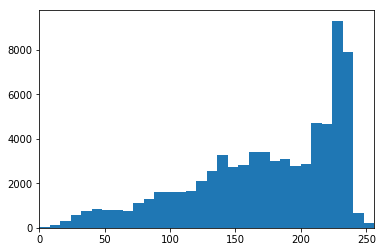

In [5]:
fig, ax = plt.subplots(1, 1)
ax.hist(text.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256);

Контролируемый порог

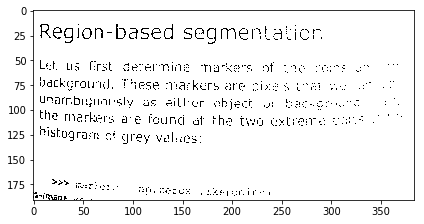

In [6]:
text_segmented = text > 50
imshow(text_segmented)

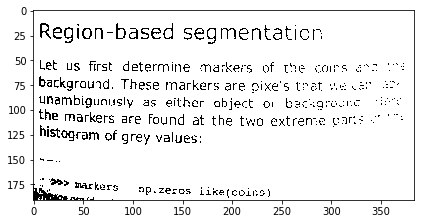

In [7]:
text_segmented = text > 70
imshow(text_segmented)

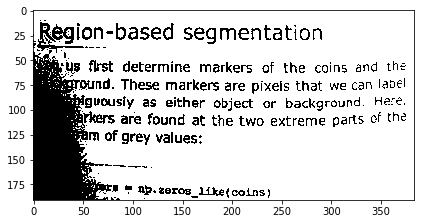

In [8]:
text_segmented = text > 120
imshow(text_segmented)

Неконтролируемый порог

In [9]:
filters.threshold_otsu
filters.threshold_local

<function skimage.filters.thresholding.threshold_local(image, block_size, method='gaussian', offset=0, mode='reflect', param=None, cval=0)>

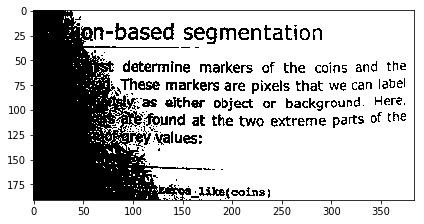

In [10]:
imshow(text > filters.threshold_li(text));

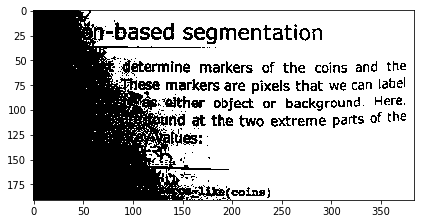

In [11]:
imshow(text > filters.threshold_otsu(text));

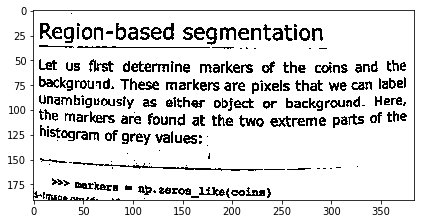

In [12]:
imshow(text > filters.threshold_local(text,block_size=51, offset=10));

## Сегментация с алгоритмом для модели с учителем


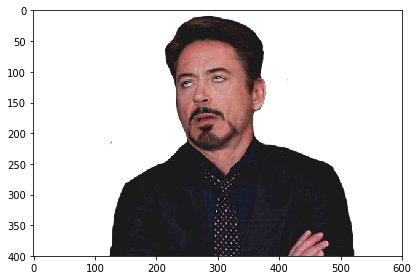

In [75]:
image = imread('imgs\starl2.png') 
imshow(image);

Перед сегментацией удаляем с изображения шум с помощью фильтров

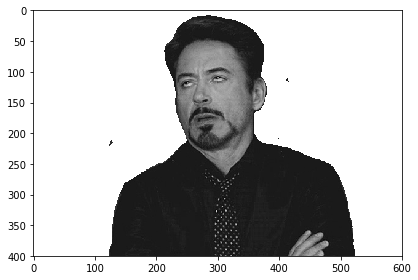

In [76]:
image_gray = color.rgb2gray(image) 
imshow(image_gray);

## Активная контурная сегментация

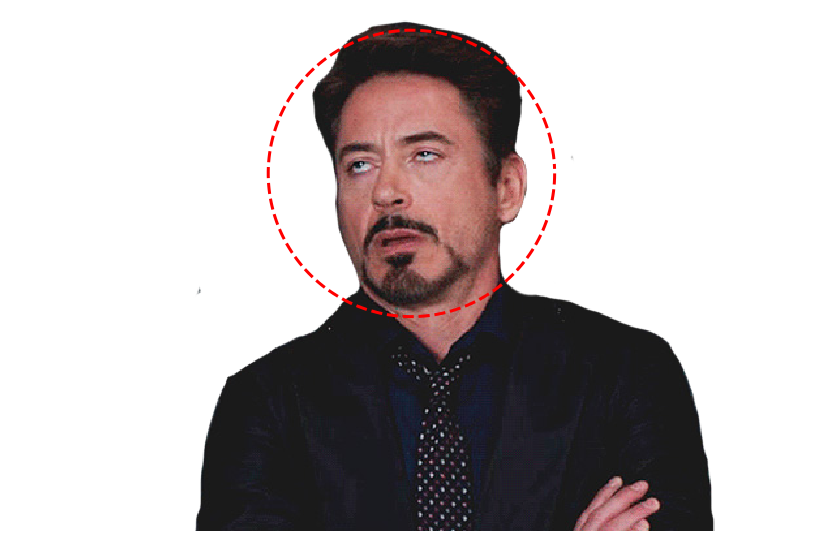

In [77]:
def circle_points(resolution, center, radius): 
    radians = np.linspace(0, 2*np.pi, resolution)
    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

points = circle_points(200, [125, 290], 110)[:-1]

fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)

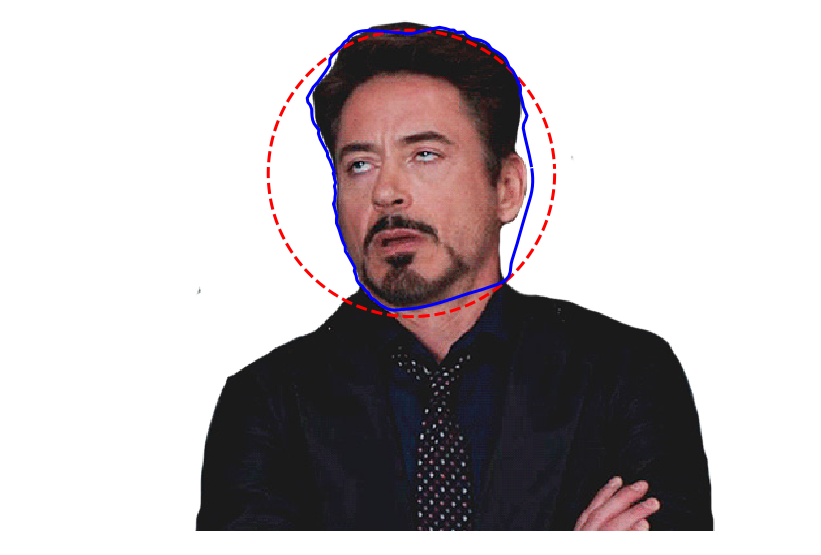

In [78]:
snake = seg.active_contour(image_gray, points,alpha=0.06,beta=0.3)
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

## Сегментация случайного прохождения

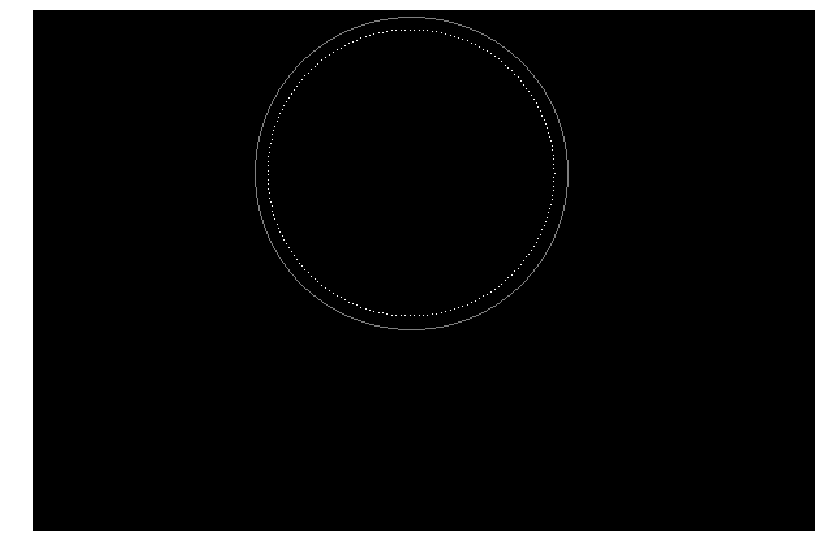

In [79]:
image_labels = np.zeros(image_gray.shape, dtype=np.uint8)
indices = draw.circle_perimeter(125, 290, 120)
image_labels[indices] = 1
image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2
image_show(image_labels);

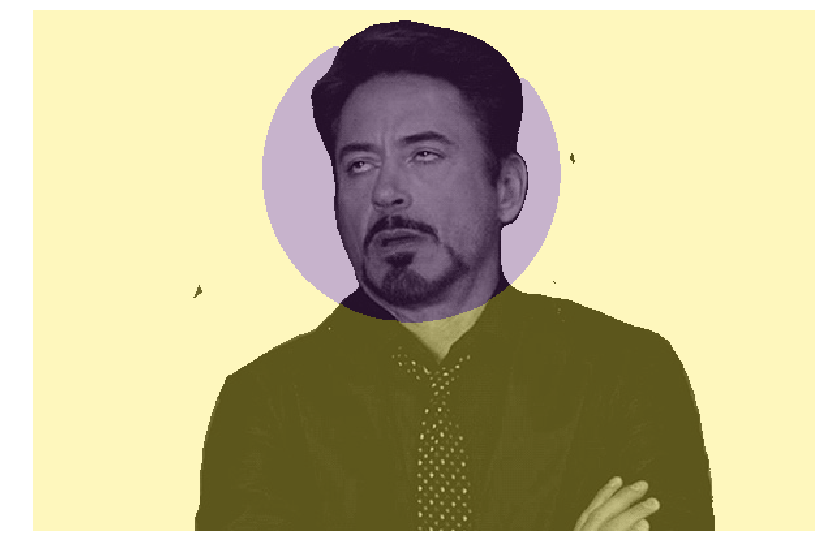

In [80]:
image_segmented = seg.random_walker(image_gray, image_labels)
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.3);

## Сегментация без учителя

## Простая Линейно-итеративная Кластеризация

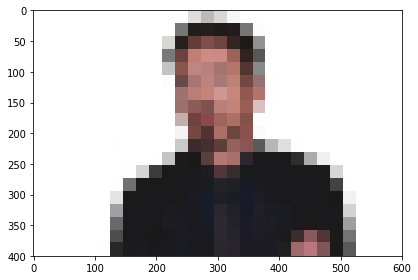

In [86]:
image_slic = seg.slic(image,n_segments=555)
imshow(color.label2rgb(image_slic, image, kind='avg'));

## Felzenszwalb

(<Figure size 1008x1008 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x23002c2f438>)

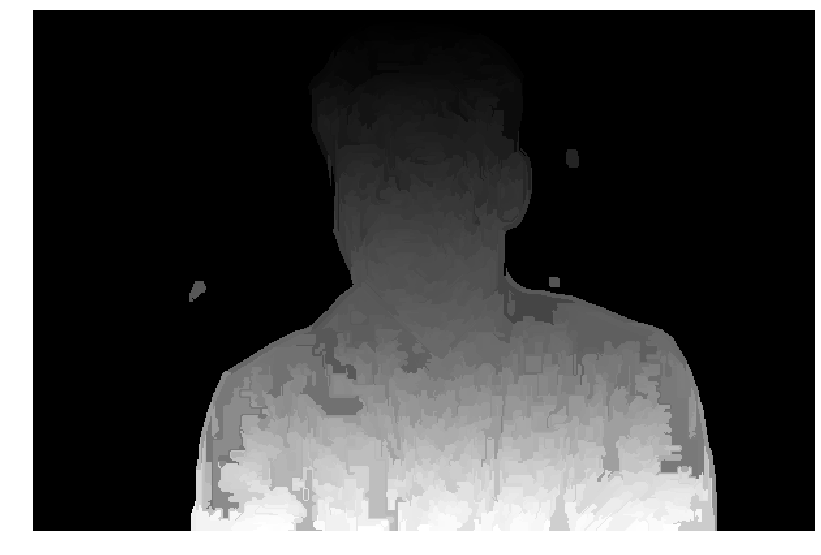

In [87]:
image_felzenszwalb = seg.felzenszwalb(image) 
image_show(image_felzenszwalb)

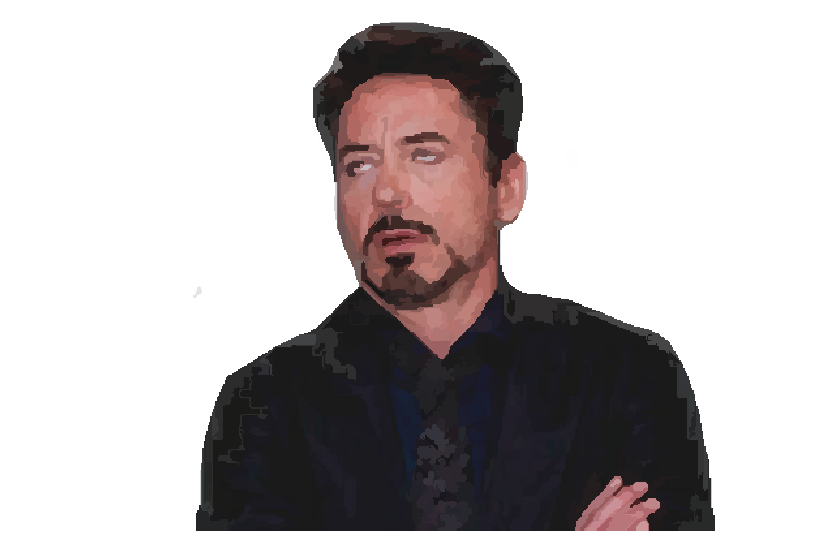

In [88]:
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, image, kind='avg')
image_show(image_felzenszwalb_colored);

## Другой пример

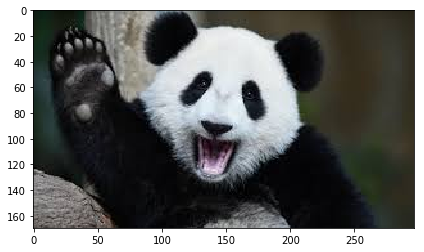

In [89]:
image = imread('imgs/panda.jpg') 
imshow(image)
image_gray = color.rgb2gray(image) 

In [91]:
image_gray.shape

(170, 297)

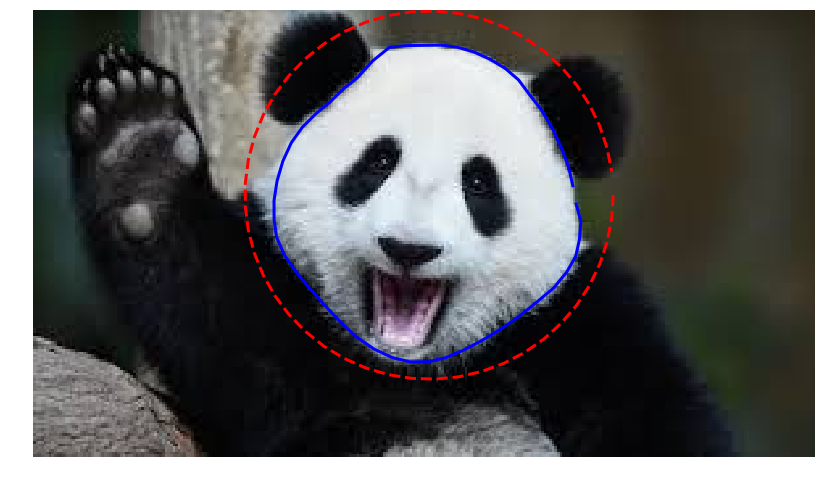

In [100]:
points = circle_points(50, [70, 150], 70)[:-1]
snake = seg.active_contour(image_gray, points,alpha=0.01,beta=0.2)
fig, ax = image_show(image)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

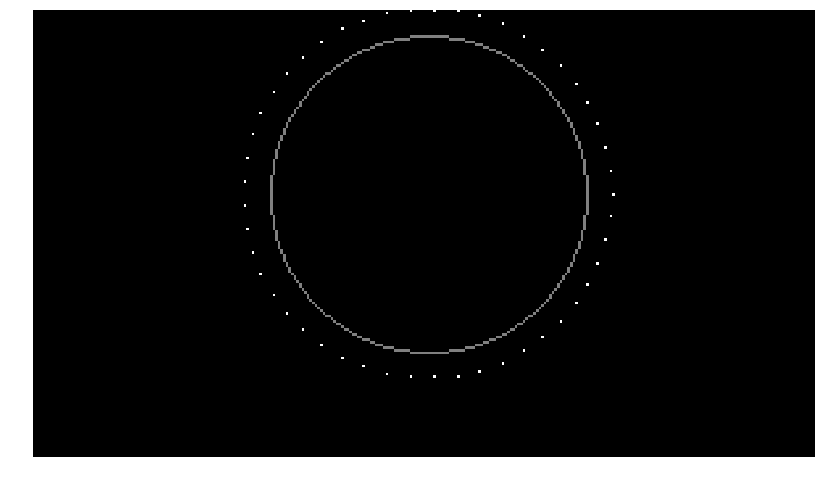

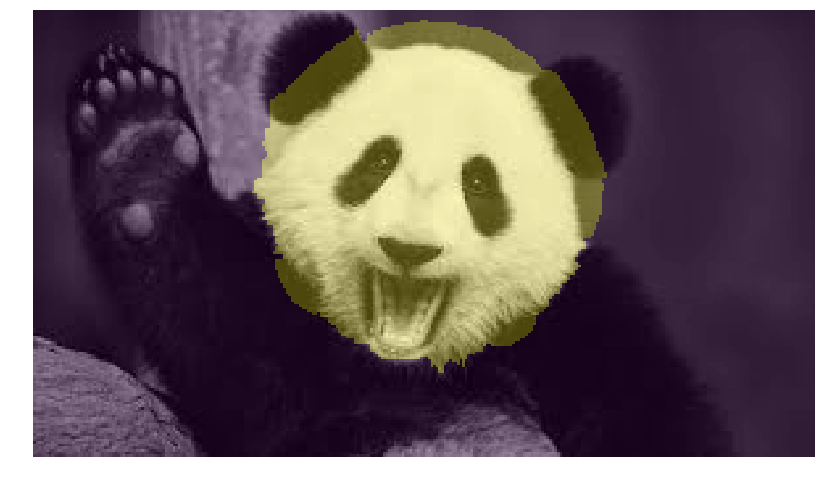

In [102]:
image_labels = np.zeros(image_gray.shape, dtype=np.uint8)
indices = draw.circle_perimeter(70, 150, 60)
image_labels[indices] = 1
image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2
image_show(image_labels)
image_segmented = seg.random_walker(image_gray, image_labels, beta = 3000)
fig, ax = image_show(image_gray)
ax.imshow(image_segmented == 1, alpha=0.3);

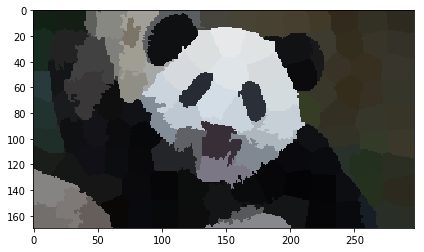

In [103]:
image_slic = seg.slic(image,n_segments=155)
imshow(color.label2rgb(image_slic, image, kind='avg'));

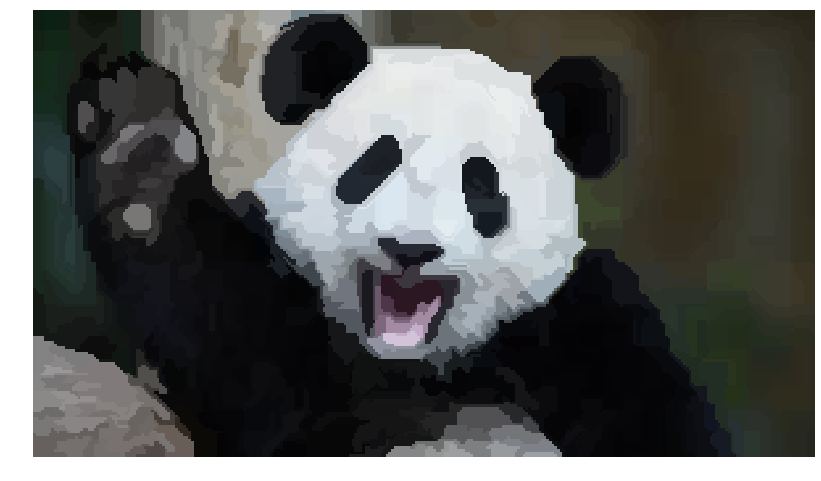

In [104]:
image_felzenszwalb = seg.felzenszwalb(image) 
image_felzenszwalb_colored = color.label2rgb(image_felzenszwalb, image, kind='avg')
image_show(image_felzenszwalb_colored);

## Сегментация на основе краев

In [105]:
coins = data.coins()
histo = np.histogram(coins, bins=np.arange(0, 256))

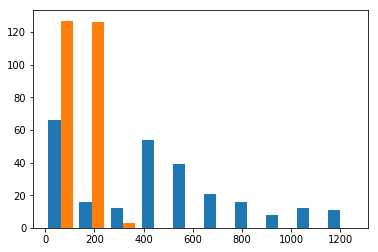

In [106]:
plt.hist(histo)
plt.show()

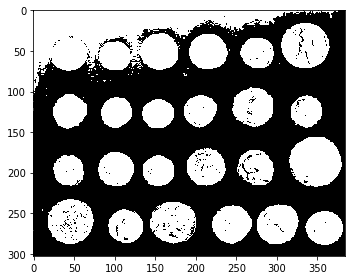

In [107]:
imshow(coins>100)

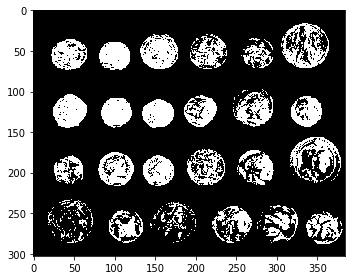

In [108]:
imshow(coins>150)

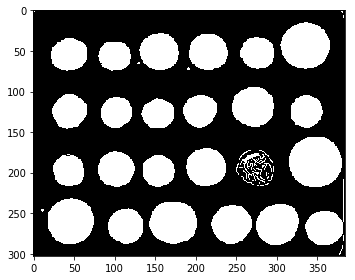

In [109]:
edges = canny(coins/255.)
fill_coins = ndi.binary_fill_holes(edges)
imshow(fill_coins)

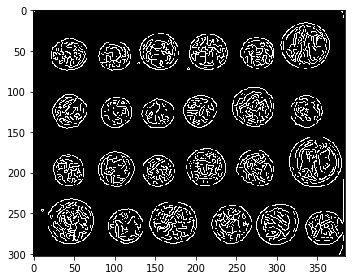

In [110]:
imshow(edges)

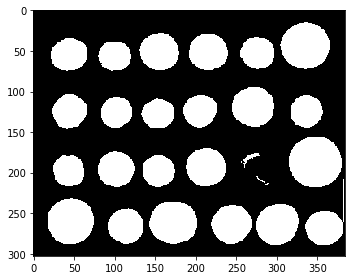

In [111]:
# удаление маленьких объектов
label_objects, nb_labels = ndi.label(fill_coins)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
coins_cleaned = mask_sizes[label_objects]
imshow(coins_cleaned)

## Сегментация по регионам


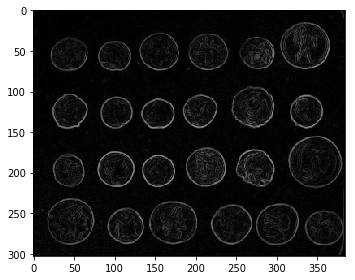

In [112]:
elevation_map = sobel(coins)
imshow(elevation_map )

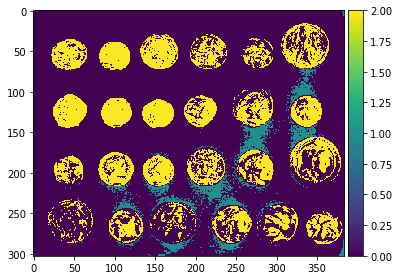

In [113]:
markers = np.zeros_like(coins)
markers[coins < 30] = 1
markers[coins > 150] = 2
imshow(markers)

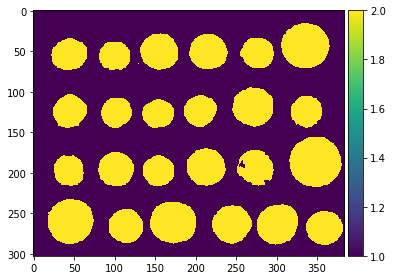

In [114]:
imshow(watershed(elevation_map, markers))

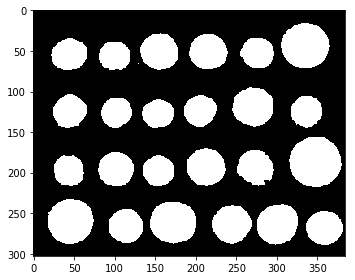

In [115]:
imshow(ndi.binary_fill_holes(watershed(elevation_map, markers) - 1))

In [116]:
labeled_coins, _ = ndi.label(ndi.binary_fill_holes(watershed(elevation_map, markers) - 1))

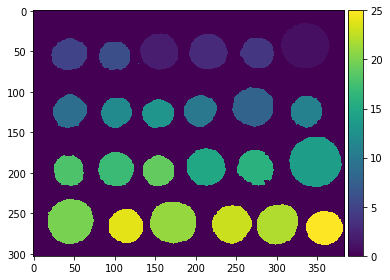

In [117]:
imshow(labeled_coins)

# OpenCV

## Подсчет количества книг

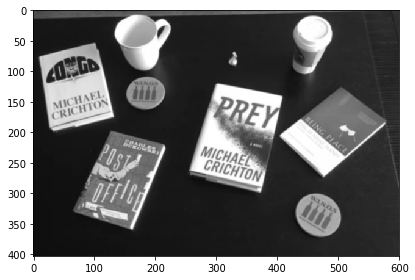

In [146]:
# загружаем изображение, 
# меняем цвет на оттенки серого
# и уменьшаем резкость
image = cv2.imread("imgs\\books.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (3, 3), 0)
gray = cv2.convertScaleAbs(gray)

imshow(gray)

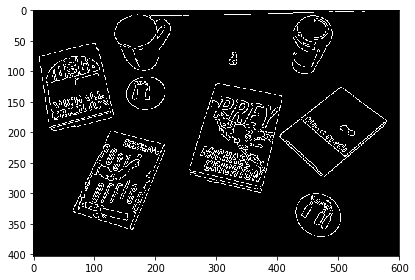

In [147]:
# распознавание контуров
edged = cv2.Canny(gray, 10, 250)
imshow(edged)

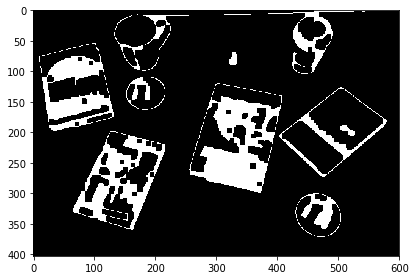

In [148]:
# применяем закрытие
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
imshow(closed)

Книг на картинке 4


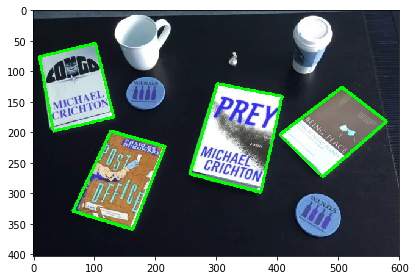

In [157]:
# находим контуры в изображении и считаем количество книг
cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
total = 0

# цикл по контурам
for c in cnts:
    # аппроксимируем (сглаживаем) контур
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # если у контура 4 вершины, предполагаем, что это книга
    if len(approx) == 4:
        cv2.drawContours(image, [approx], -1, (0, 255, 0), 4)
        total += 1

print("Книг на картинке",total)   
imshow(image)

## Пространственные манипуляции с изображением

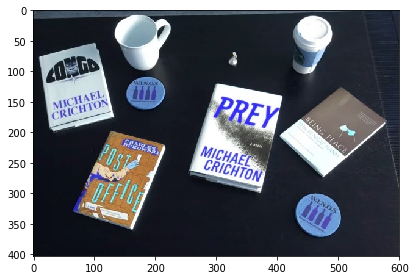

In [139]:
image = cv2.imread("imgs\\books.jpg")
imshow(image)

### уменьшаем изображение

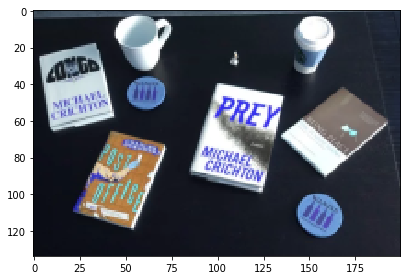

In [140]:
final_wide = 200
r = float(final_wide) / image.shape[1]
dim = (final_wide, int(image.shape[0] * r))
 
# уменьшаем изображение до подготовленных размеров
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
imshow(resized)

### вырезаем нужный фрагмент изображения

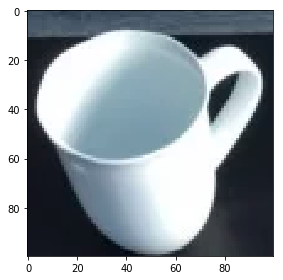

In [141]:
cropped = image[0:100, 130:230]
imshow(cropped)

### поворот изображения

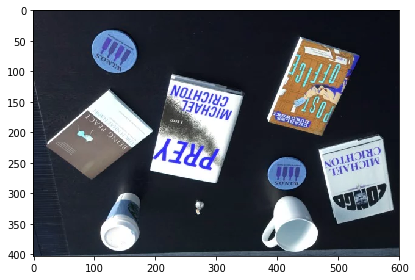

In [142]:
# получим размеры изображения для поворота
# и вычислим центр изображения
(h, w) = image.shape[:2]
center = (w / 2, h / 2)
 
# повернем изображение на 180 градусов
M = cv2.getRotationMatrix2D(center, 180, 1.0)
rotated = cv2.warpAffine(image, M, (w, h))
imshow(rotated)

### отражение изображения по осям

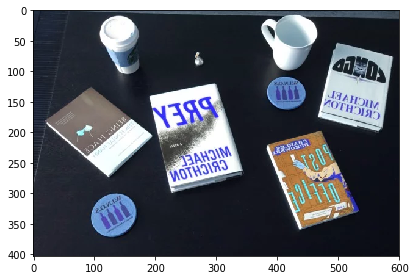

In [143]:
flip_image = cv2.flip(image,1)
imshow(flip_image)

### сохранение изображения

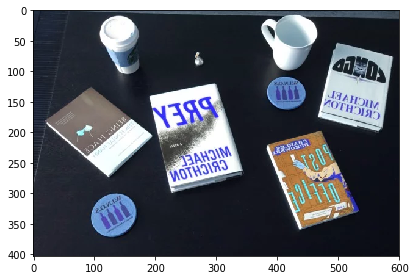

In [144]:
cv2.imwrite("imgs\\flip.png", flip_image)
flip_image = cv2.imread("imgs\\flip.png")
imshow(flip_image)